<a href="https://colab.research.google.com/github/sdchen6/PrivacyPlate/blob/main/pp_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Extraction from XML Files

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install -U yolov5

In [ ]:
import xml.etree.ElementTree as ET
import os
import sys
from collections import defaultdict

from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as patches
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Test XML Data Extraction: License Plate Crop Borders

In [ ]:
# Path to annotation folder
annot_dir_path = Path("/content/drive/MyDrive/01-License Plates/annotations")

if not annot_dir_path.exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

# Extract the box from xml files
box_locations = defaultdict(list)
box_sizes = defaultdict(list)
box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location
box_size_elements = ['width', 'height'] # order of image size

for path in os.listdir(annot_dir_path):
    tree = ET.parse(f'{annot_dir_path}/{path}')  # Replace 'your_xml_file.xml' with your XML file path
    root = tree.getroot()

    # Get key from XML
    xml_ind =int(path[4:-4])

    for element in box_elements:
        box_locations[xml_ind].append(int(root.find('object').find('bndbox').find(element).text))

    for element in box_size_elements:
        box_sizes[xml_ind].append(int(root.find('size').find(element).text))

max_w = 0
max_h = 0
for w, h in box_sizes.values():
    if max_w < w:
        max_w = w
    if max_h < h:
        max_h = h

print('Max Width = ', max_w)
print('Max Height = ', max_h)

Max Width =  600
Max Height =  531


# 2. Test License Plate Image Data Import

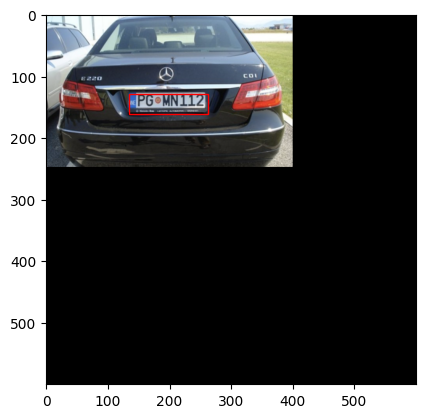

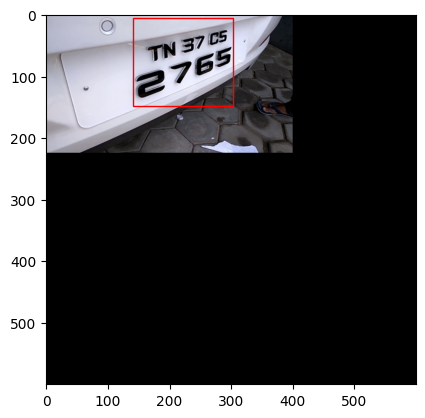

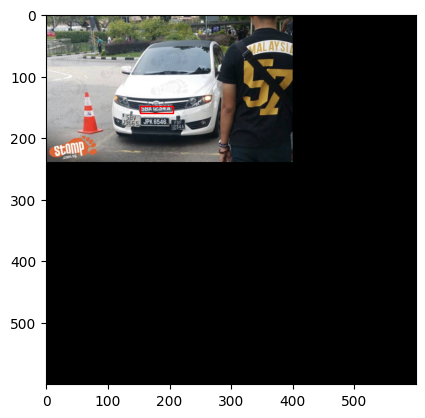

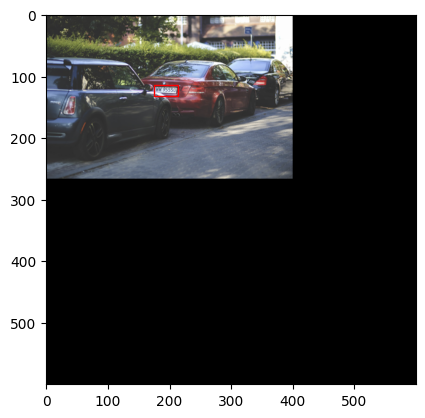

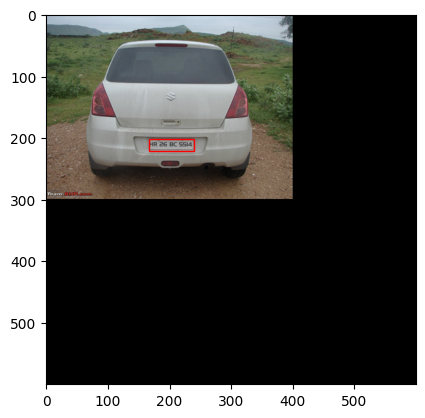

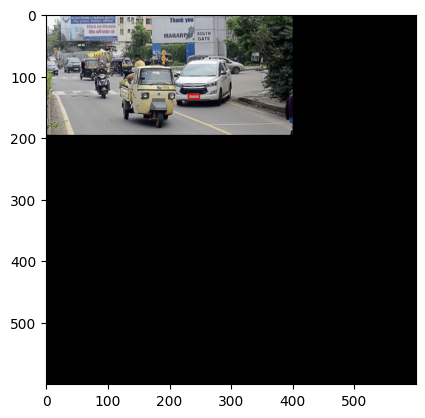

In [ ]:
img_dir_path = Path("/content/drive/MyDrive/01-License Plates/paddedimages")

if not img_dir_path.exists():
  print("Image directory path does not exist")
  sys.exit(1)

images = []

i = 0
for i, path in enumerate(os.listdir(img_dir_path)):
  image = mpimg.imread(f"{img_dir_path}/{path}")
  fig, ax = plt.subplots()

  ax.imshow(image)

  # Red box around to see the license plate
  box = box_locations[int(path[4:-4])]
  rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

  plt.show()


  i += 1
  if i > 5:
    break

# 3. Preprocess Data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [ ]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        # Initialize your dataset here
        ############################# self.img_dir_path = data_dir + "/images"
        self.img_dir_path = data_dir + "/paddedimages"
        self.annot_dir_path = data_dir + "/annotations"
        self.transform = transform
        self.image_and_box = [set() for i in range(len(os.listdir(f"{self.img_dir_path}")))]
        self.box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location
        self.box_size_elements = ['width', 'height']

        # populate image paths
        for path in os.listdir(self.img_dir_path):
            # Get box location info here
            tree = ET.parse(f'{self.annot_dir_path}/{path[:-4]}.xml')  # Replace 'your_xml_file.xml' with your XML file path
            root = tree.getroot()

            # Get key from XML
            xml_ind = int(path[4:-4])
            box_location = []
            box_sizes = []
            for element in self.box_elements:
                box_location.append(int(root.find('object').find('bndbox').find(element).text))

            for element in self.box_size_elements:
                box_sizes.append(int(root.find('size').find(element).text))

            # Add to image paths
            xml_ind = int(path[4:-4])
            self.image_and_box[xml_ind] = (f"{self.img_dir_path}/{path}", box_location, box_sizes)

    def __len__(self):
        # Return the number of samples in your dataset
        return len(self.image_and_box)

    def __getitem__(self, index):
        # Load and preprocess the data at the specified index
        image_path, label, size = self.image_and_box[index]

        # Show data for now
        image = mpimg.imread(image_path)
        # fig, ax = plt.subplots()

        # padded_image = np.pad(image, ((0, 600 - size[1]), (0, 600 - size[0]), (0, 0)))
        # ax.imshow(padded_image)

        # Red box around to see the license plate
        # print("Label: ", label)
        # rect = patches.Rectangle((label[0], label[1]), label[2] - label[0], label[3] - label[1], linewidth=1, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)

        # plt.show()

        # return (padded_image, label)
        return (image, label)

In [ ]:
data_dir = "/content/drive/MyDrive/01-License Plates"

if not Path(data_dir).exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

# TODO: Add resizing without changign aspect ratio
# transform = transforms.Compose([transforms.Resize((224, 224))]) # fill in gray area to 512 x 512

license_plates_dataset = CarDataset(data_dir)
license_plates_dataset[2]

# 433 is the length of the dataset
images = []
labels = []
for i in range(433):
    data = license_plates_dataset[i]
    images.append(data[0])
    labels.append(data[1])

print(labels)

[[226, 125, 419, 173], [134, 128, 262, 160], [229, 176, 270, 193], [142, 128, 261, 157], [156, 82, 503, 253], [226, 218, 242, 240], [112, 114, 373, 239], [166, 141, 206, 154], [204, 104, 304, 134], [164, 224, 272, 247], [140, 5, 303, 148], [131, 206, 273, 234], [122, 82, 277, 117], [191, 147, 242, 169], [94, 118, 274, 163], [310, 146, 372, 171], [36, 175, 62, 186], [306, 188, 351, 205], [313, 286, 405, 311], [148, 195, 221, 232], [18, 135, 48, 152], [191, 165, 255, 192], [207, 104, 260, 116], [143, 172, 213, 211], [167, 202, 240, 221], [177, 139, 216, 159], [258, 184, 321, 213], [148, 127, 245, 159], [541, 366, 598, 384], [143, 171, 211, 208], [155, 169, 200, 182], [286, 173, 400, 211], [200, 149, 251, 167], [94, 56, 306, 169], [147, 181, 260, 206], [91, 186, 137, 208], [203, 193, 285, 229], [146, 114, 246, 163], [168, 196, 240, 231], [225, 180, 328, 213], [261, 186, 317, 211], [109, 182, 159, 206], [177, 140, 217, 159], [142, 111, 319, 161], [18, 153, 430, 271], [204, 103, 280, 175], 

# CNN Model

In [ ]:
# Create CNN model
class ConvNeuralNet(nn.Module):
    def __init__(self):
        super(ConvNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=32 * 150 * 150, out_features=200)
        self.fc2 = nn.Linear(200, 4)

    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# # Transform data into grayscale
# my_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.ToPILImage(),
#     transforms.Grayscale(),
#     transforms.ToTensor()])

# greyscale_images = list(map(my_transform, images))

In [ ]:
# Create train-val-test splits and dataloader
train_idx, test_idx, train_labels, test_labels = train_test_split(
    range(433), labels, test_size=0.25, random_state=0)

val_idx, test_idx, val_labels, test_labels = train_test_split(
    test_idx, test_labels, test_size=0.6, random_state=0)

# create the subsets from the greyscale_images dataset
train_data = torch.utils.data.Subset(license_plates_dataset, train_idx)
val_data = torch.utils.data.Subset(license_plates_dataset, val_idx)
test_data = torch.utils.data.Subset(license_plates_dataset, test_idx)

# create the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16)

print('Train Set Size:', len(train_labels))
print('Val Set Size:', len(val_labels))
print('Test Set Size:', len(test_labels))

NameError: ignored

In [ ]:
model = ConvNeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

loss_train_lst = []
loss_valid_lst = []
# train_accuracy_lst = []
# valid_accuracy_lst = []

In [ ]:
for epoch in range(10):
    loss_training = 0.0
    loss_valid = 0.0

    model.train()

    train_predictions = []
    train_true = []

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(type(inputs))
        # print(inputs.size())
        inputs = inputs.permute(0, 3, 1, 2)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = model(inputs)
        loss = criterion(logits, torch.Tensor([labels]))
        loss.backward()
        optimizer.step()

        loss_training += loss.item()

        train_predictions.extend(logits)
        train_true.extend(labels)


    model.eval()
    valid_predictions = []
    valid_true = []

    # Iterate over the validation set and calculate loss and accuracy
    for i, data in enumerate(val_loader):
        inputs, labels = data
        inputs = inputs.permute(0, 3, 1, 2)
        logits = model(inputs)
        loss = criterion(logits, torch.Tensor([labels]))

        loss_valid += loss.item()

        valid_predictions.extend(logits)
        valid_true.extend(labels)

    loss_train_lst.append(loss_training)
    loss_valid_lst.append(loss_valid)

    print('Epoch', epoch)
    print(loss_training)
    print(loss_valid)

    # train_accuracy_lst.append(accuracy_score(train_true, train_predictions))
    # valid_accuracy_lst.append(accuracy_score(valid_true, valid_predictions))

tensor(796.6198, grad_fn=<DivBackward1>)
tensor(7096.6431, grad_fn=<DivBackward1>)
tensor(4767.7339, grad_fn=<DivBackward1>)
tensor(9102.9805, grad_fn=<DivBackward1>)
tensor(1373.7468, grad_fn=<DivBackward1>)
tensor(841.8090, grad_fn=<DivBackward1>)
tensor(647.2484, grad_fn=<DivBackward1>)
tensor(928.1804, grad_fn=<DivBackward1>)
tensor(1583.1927, grad_fn=<DivBackward1>)
tensor(1020.8802, grad_fn=<DivBackward1>)
tensor(862.6003, grad_fn=<DivBackward1>)
tensor(1325.2800, grad_fn=<DivBackward1>)
tensor(1335.8448, grad_fn=<DivBackward1>)
tensor(1302.1189, grad_fn=<DivBackward1>)
tensor(704.2930, grad_fn=<DivBackward1>)
tensor(1460.7263, grad_fn=<DivBackward1>)
tensor(1496.6969, grad_fn=<DivBackward1>)
tensor(1129.2877, grad_fn=<DivBackward1>)
tensor(679.6768, grad_fn=<DivBackward1>)
tensor(1479.3083, grad_fn=<DivBackward1>)
tensor(1160.2078, grad_fn=<DivBackward1>)
tensor(1553.8474, grad_fn=<DivBackward1>)
tensor(907.7118, grad_fn=<DivBackward1>)
tensor(672.8129, grad_fn=<DivBackward1>)
t